In [1]:
import pickle
import numpy as np

In [154]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')

In [104]:
# Load data from each band (assuming files are named accordingly)
with open('processed_data/pd_on vs hc/delta.pkl', 'rb') as f:
    delta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/theta.pkl', 'rb') as f:
    theta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/alpha.pkl', 'rb') as f:
    alpha_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/beta.pkl', 'rb') as f:
    beta_data = pickle.load(f)['data']
with open('processed_data/pd_on vs hc/gamma.pkl', 'rb') as f:
    gamma_data = pickle.load(f)['data']

# Stack the bands along the third dimension
data = np.stack([delta_data, theta_data, alpha_data, beta_data, gamma_data], axis=-1)  # shape: (5580, 32, 5)

In [5]:
import matplotlib.pyplot as plt

In [6]:
data.shape

(5580, 32, 5)

In [105]:
with open('processed_data/pd_on vs hc/delta.pkl', 'rb') as f:
    labels = pickle.load(f)['labels']

In [ ]:
import torch
import torch.nn as nn

print(f'Using device: {device}')

# Set device to CUDA if availabledevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [106]:
from sklearn.preprocessing import StandardScaler

data = data.reshape(-1, data.shape[-2] * data.shape[-1])
scaler = StandardScaler()
data = scaler.fit_transform(data).reshape(-1, 1, 32, 5)

In [107]:
import numpy as np

# Shuffle data and labels together
indices = np.random.permutation(len(data))
data = data[indices]
labels = labels[indices]

In [ ]:
train_ratio = 0.7
val_ratio = 0.1
test_ratio = 0.2

train_index = 0, int(data.shape[0] * train_ratio)
test_index = train_index[1], int(data.shape[0] * (train_ratio + test_ratio))
val_index = test_index[1], data.shape[0]

data = torch.tensor(data).float().to(device)
labels = torch.tensor(labels).float().to(device)

X_tr, Y_tr = data[train_index[0] :train_index[1]], labels[train_index[0] :train_index[1]]
X_test, Y_test = data[test_index[0] :test_index[1]], labels[test_index[0] :test_index[1]]
X_val, Y_val = data[val_index[0] :val_index[1]], labels[val_index[0] :val_index[1]]

In [39]:
X_tr.shape

torch.Size([3905, 32, 5, 1])

In [142]:
class ConvBlock(nn.Module):
    def __init__(self, in_chans, out_chans):
        super().__init__()

        self.block = nn.Sequential(
            nn.Conv2d(in_channels=in_chans, out_channels=out_chans, kernel_size=(3, 3), padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 1)),
            nn.Dropout(0.3),
        )

    def forward(self, x):
        return self.block(x)


class ParkinsonsModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.blocks = nn.Sequential(
            ConvBlock(1, 32),
            ConvBlock(in_chans=32, out_chans=64),
            ConvBlock(in_chans=64, out_chans=128),
            ConvBlock(in_chans=128, out_chans=256),
            ConvBlock(in_chans=256, out_chans=512),
        )

        self.project = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2560, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.blocks(x)
        x = self.project(x)

        return x

In [ ]:
model = ParkinsonsModel().to(device)
print(f'Model moved to {device}')
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
)


losses = []
val_losses = []
val_accuracies = []

In [ ]:
# Create checkpoints directory
import os
os.makedirs('checkpoints', exist_ok=True)

In [ ]:
BATCH_SIZE = 32

for i in range(5_000_000):
    batch_ix = torch.randint(0, X_tr.shape[0], (32,))
    x, y = X_tr[batch_ix], Y_tr[batch_ix]


    pred = model(x)
    loss = torch.functional.F.binary_cross_entropy(pred, y.view(-1,1))
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    with torch.no_grad():
        batch_ix = torch.randint(0, X_val.shape[0], (32,))
        val_pred = model(X_val)
        val_loss = torch.functional.F.binary_cross_entropy(val_pred, Y_val.view(-1,1))
        val_accuracy = ((val_pred > 0.5).float() == Y_val.view(-1,1)).float().mean()
        val_losses.append(val_loss.item())
        val_accuracies.append(val_accuracy.item())

    if i % 100 == 0:
        print(f"epoch: {i}, loss: {loss.item():.3f}, val_loss: {val_loss.item():.3f}, val_acc: {val_accuracy.item():.3f}")

    if i % 50_000 == 0 and i > 0:
        checkpoint = {
            'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,
            'val_losses': val_losses,
            'val_accuracies': val_accuracies,
        }
        torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{i}.pt')
        print(f"Checkpoint saved at epoch {i}")


epoch: 0, loss: 0.708, val_loss: 0.691
epoch: 100, loss: 0.698, val_loss: 0.687
epoch: 200, loss: 0.702, val_loss: 0.683
epoch: 300, loss: 0.689, val_loss: 0.648
epoch: 400, loss: 0.551, val_loss: 0.600
epoch: 500, loss: 0.562, val_loss: 0.531
epoch: 600, loss: 0.804, val_loss: 0.432
epoch: 700, loss: 0.419, val_loss: 0.376
epoch: 800, loss: 0.244, val_loss: 0.338
epoch: 900, loss: 0.189, val_loss: 0.320
epoch: 1000, loss: 0.257, val_loss: 0.325


KeyboardInterrupt: 

NameError: name 'val_accuracies' is not defined

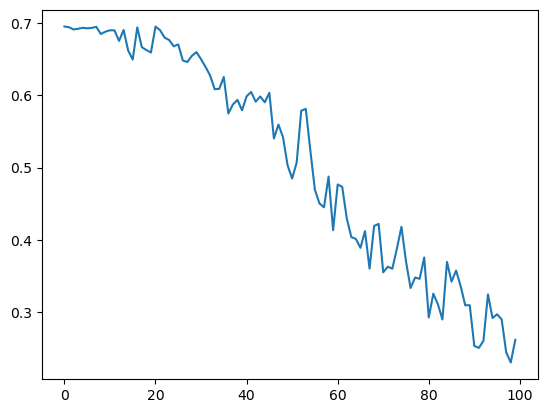

In [153]:
plt.plot(torch.tensor(losses[:-77]).view(-1, 10).mean(1))
plt.plot(torch.tensor(val_losses[:-77]).view(-1, 10).mean(1))
plt.plot(val_accuracies)

In [122]:
model.eval()
val_losses = []
with torch.no_grad():
    for i in range(1000):
        batch_ix = torch.randint(0, X_val.shape[0], (32,))
        x, y = X_val[batch_ix], Y_val[batch_ix]


        pred = model(x)
        loss = torch.functional.F.binary_cross_entropy(pred, y.view(-1,1))
        val_losses.append(loss.item())

val_loss = torch.tensor(val_losses).mean()
print(f'val loss: {val_loss}')

val loss: 0.08258762955665588


In [103]:
Y_tr.size(), Y_tr.sum()

(torch.Size([3905]), tensor(1888.))

In [123]:
def calculate_metrics(model, X, Y, threshold=0.5):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
        predicted_labels = (predictions >= threshold).float()
        
        # Calculate confusion matrix components
        TP = ((predicted_labels == 1) & (Y.view(-1, 1) == 1)).sum().item()
        TN = ((predicted_labels == 0) & (Y.view(-1, 1) == 0)).sum().item()
        FP = ((predicted_labels == 1) & (Y.view(-1, 1) == 0)).sum().item()
        FN = ((predicted_labels == 0) & (Y.view(-1, 1) == 1)).sum().item()
        
        # Calculate metrics
        accuracy = (TP + TN) / (TP + TN + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall, TPR
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0  # TNR
        
        return {
            'accuracy': accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'confusion_matrix': {
                'TP': TP, 'TN': TN, 'FP': FP, 'FN': FN
            }
        }

# Calculate metrics for validation set
val_metrics = calculate_metrics(model, X_val, Y_val)

print("Validation Metrics:")
print(f"Accuracy:    {val_metrics['accuracy']:.4f}")
print(f"Sensitivity: {val_metrics['sensitivity']:.4f} (ability to detect PD)")
print(f"Specificity: {val_metrics['specificity']:.4f} (ability to detect HC)")
print(f"\nConfusion Matrix:")
print(f"  TP (PD→PD): {val_metrics['confusion_matrix']['TP']}")
print(f"  TN (HC→HC): {val_metrics['confusion_matrix']['TN']}")
print(f"  FP (HC→PD): {val_metrics['confusion_matrix']['FP']}")
print(f"  FN (PD→HC): {val_metrics['confusion_matrix']['FN']}")

Validation Metrics:
Accuracy:    0.9767
Sensitivity: 0.9734 (ability to detect PD)
Specificity: 0.9797 (ability to detect HC)

Confusion Matrix:
  TP (PD→PD): 256
  TN (HC→HC): 290
  FP (HC→PD): 6
  FN (PD→HC): 7


In [ ]:
# Visualize confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(metrics, title="Confusion Matrix"):
    cm = metrics['confusion_matrix']
    matrix = np.array([[cm['TN'], cm['FP']], 
                       [cm['FN'], cm['TP']]])
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['HC', 'PD'], yticklabels=['HC', 'PD'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_metrics, "Test Set Confusion Matrix")

In [ ]:
# Calculate metrics for test set
test_metrics = calculate_metrics(model, X_test, Y_test)

print("Test Metrics:")
print(f"Accuracy:    {test_metrics['accuracy']:.4f}")
print(f"Sensitivity: {test_metrics['sensitivity']:.4f}")
print(f"Specificity: {test_metrics['specificity']:.4f}")
print(f"\nConfusion Matrix:")
print(f"  TP: {test_metrics['confusion_matrix']['TP']}")
print(f"  TN: {test_metrics['confusion_matrix']['TN']}")
print(f"  FP: {test_metrics['confusion_matrix']['FP']}")
print(f"  FN: {test_metrics['confusion_matrix']['FN']}")

In [33]:
data.reshape(-1, data.shape[-2] * data.shape[-1]).shape

torch.Size([5580, 160])